In [71]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import time
import sys
#%load_ext ipycache

import random
import re
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import json

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))
from joblib import Memory

memory = Memory("./cachedir", verbose=0)

@memory.cache
def my_function(x):
    # Long computation here
    return x ** 2


# Loading the Data

In [2]:
file_path = 'booksummaries.csv'
rows = []

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip().strip('"')
        rows.append(line.split('\t'))

books = pd.DataFrame(rows)

books.columns = ['ID', 'MID', 'Title', 'Author', 'Publication Date', 'Genres', 'Summary']

for col in books.columns:
    books[col] = books[col].str.strip().str.strip('"')

books['Genres'] = books['Genres'].apply(lambda x: re.sub(r'""', '"', x) if isinstance(x, str) else x)

books.to_csv("book_summaries_cleaned.csv", index=False, header=False)

print(books.head())

     ID      MID                                      Title           Author  \
0   620  /m/0hhy                                Animal Farm    George Orwell   
1   843  /m/0k36                         A Clockwork Orange  Anthony Burgess   
2   986  /m/0ldx                                 The Plague     Albert Camus   
3  1756  /m/0sww  An Enquiry Concerning Human Understanding       David Hume   
4  2080  /m/0wkt                       A Fire Upon the Deep     Vernor Vinge   

  Publication Date                                             Genres  \
0       1945-08-17  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1             1962  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2             1947  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
3                                                                       
4                   {"/m/03lrw": "Hard science fiction", "/m/06n90...   

                                             Summary  
0  Old Major, the old boa

In [3]:
import pandas as pd
import ast

def extract_genres(genre_string):
    try:
        genre_dict = ast.literal_eval(genre_string)
        return [genre for genre in genre_dict.values()]
    except (ValueError, SyntaxError):
        return []

books['Genres'] = books['Genres'].apply(extract_genres)

print(books[['Genres']].head())

                                              Genres
0  [Roman à clef, Satire, Children's literature, ...
1  [Science Fiction, Novella, Speculative fiction...
2  [Existentialism, Fiction, Absurdist fiction, N...
3                                                 []
4  [Hard science fiction, Science Fiction, Specul...


In [4]:
books = books.drop(columns = ['MID'])
books.head()

,ID,Title,Author,Publication Date,Genres,Summary
0,620,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, cal..."
1,843,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future England..."
2,986,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five pa...
3,1756,An Enquiry Concerning Human Understanding,David Hume,,[],The argument of the Enquiry proceeds by a seri...
4,2080,A Fire Upon the Deep,Vernor Vinge,,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky W...


# Data Exploration and Preparation

In [5]:
for i in range(5):
    print(books.loc[i, "Title"])

Animal Farm
A Clockwork Orange
The Plague
An Enquiry Concerning Human Understanding
A Fire Upon the Deep


In [6]:
print(books.loc[0, "Summary"])

Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm, renaming it ""Animal Farm"". They adopt Seven Commandments of Animal-ism, the most important of which is, ""All animals are equal"". Snowball attempts to teach the animals reading and writing; food is plentiful, and the farm runs smoothly. The pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. Napoleon takes the pups from the farm dogs and trains them privately. Napoleon and Snowball struggle for leadership. When Snowball announces his plans to build a windmill, Napoleon has his dogs chase Snowball away and declares himself leader. N

In [7]:
import spacy
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = nlp.Defaults.stop_words

In [8]:
custom_stopwords = {
    "book", "novel", "story", "plot", "tale", "volume", "chapter", "series",
    "character", "hero", "villain", "friend", "adventure", "journey", "world", 
    "life", "day", "year", "people", "family", "love", "war", "battle", "conflict", 
    "quest", "time", "place", "day", "new", "young", "old", "great", "good", "bad", 
    "evil", "strange", "ordinary", "dark", "bright", "small", "large", "big", "main", 
    "first", "last", "true", "false", "real", "after", "before", "then", "later", 
    "eventually", "finally", "soon", "again", "now", "next", "meanwhile", "while",
    "through", "between", "among", "say", "said", "think", "thought", "tell", "told", 
    "know", "knew", "come", "came", "go", "went", "see", "saw", "look", "looked", "take", 
    "took", "find", "found", "make", "made", "give", "given", "start", "started", "end", 
    "ended", "begin", "began", "murder", "detective", "case", "man", "father", "home",
    "finds", "mother", "house", "years", "death", "takes", "way", "help", "begins", 
    "away", "named", "tells", "goes", "return", "son", "city", "having", "wife", "night", 
    "killed", "woman", "school", "friends", "children", "like", "work", "mr",
    'called', 'meets', 'decides', 'group', 'returns', 'leave', 'comes', 'daughter', 
    'escape', 'order', 'leaves', 'makes', 'brother', 'tries', 'finds', 'discovers', 
    'learns', 'helps', 'needs', 'second', 'including', 'little', 'first', 'many', 'others'

}

all_stopwords = spacy_stopwords.union(custom_stopwords)

In [9]:
def clean_words(summary):
    words = summary.split()
    cleaned_words = [word.lower() for word in words if word.lower() not in all_stopwords and len(word) > 2]
    return cleaned_words

In [10]:
#books['Summary'] = books['Summary'].apply(clean_words)

In [11]:
def clean_summary(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in all_stopwords and len(word)>4)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [12]:
books['Summary'] = books['Summary'].apply(clean_summary)
books.head()

,ID,Title,Author,Publication Date,Genres,Summary
0,620,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...",major manor calls animals meeting compares hum...
1,843,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...",teenager living nearfuture england leads night...
2,986,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",plague divided parts thousands initially unnot...
3,1756,An Enquiry Concerning Human Understanding,David Hume,,[],argument enquiry proceeds incremental steps se...
4,2080,A Fire Upon the Deep,Vernor Vinge,,"[Hard science fiction, Science Fiction, Specul...",posits space milky divided concentric layers z...


In [13]:
books['Summary length'] = books['Summary'].apply(lambda x: len(x))

books.head()

,ID,Title,Author,Publication Date,Genres,Summary,Summary length
0,620,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...",major manor calls animals meeting compares hum...,3232
1,843,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...",teenager living nearfuture england leads night...,3379
2,986,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",plague divided parts thousands initially unnot...,3439
3,1756,An Enquiry Concerning Human Understanding,David Hume,,[],argument enquiry proceeds incremental steps se...,8771
4,2080,A Fire Upon the Deep,Vernor Vinge,,"[Hard science fiction, Science Fiction, Specul...",posits space milky divided concentric layers z...,2642


In [14]:
def max_article_length(books_df):
    return books_df['Summary length'].max()

def min_article_length(books_df):
    return books_df['Summary length'].min()

print('Maximum summary text length is: {}'.format(max_article_length(books)))
print('Minimum summary text length is: {}'.format(min_article_length(books)))

Maximum summary text length is: 19665
Minimum summary text length is: 0


In [15]:
longest_article = None
shortest_article = None

for i in range(len(books)):
    if books.loc[i, 'Summary length'] == max_article_length(books):
        longest_article = [books.loc[i, 'Title'], books.loc[i, 'Summary length']]

for i in range(len(books)):
    if books.loc[i, 'Summary length'] == min_article_length(books):
        shortest_article = [books.loc[i, 'Title'], books.loc[i, 'Summary length']]

In [16]:
print(longest_article)
print(shortest_article)

['Dawkins vs. Gould', 19665]
['Deathstalker Destiny', 0]


# Most Popular Books

In [17]:
def title_freq_generator(books_df):
    title_frequencies = []
    unique_titles = books_df['Title'].unique()
    
    for i, title in enumerate(unique_titles):
        freq = books_df['Title'].value_counts().get(title, 0) - 1
        title_frequencies.append((title, freq))
        
        if (i + 1) % 1000 == 0:
            print('{} title frequencies have been processed.'.format(i + 1))
    
    return title_frequencies

title_frequencies = title_freq_generator(books)

1000 title frequencies have been processed.
2000 title frequencies have been processed.
3000 title frequencies have been processed.
4000 title frequencies have been processed.
5000 title frequencies have been processed.
6000 title frequencies have been processed.
7000 title frequencies have been processed.
8000 title frequencies have been processed.
9000 title frequencies have been processed.
10000 title frequencies have been processed.
11000 title frequencies have been processed.
12000 title frequencies have been processed.
13000 title frequencies have been processed.
14000 title frequencies have been processed.
15000 title frequencies have been processed.
16000 title frequencies have been processed.


In [18]:
most_frequent_mentions = sorted(title_frequencies, key=lambda x: x[1], reverse=True)
most_frequent_mentions[25:50]

[('The Keep', 2),
 ('The Enemy', 2),
 ('Reckless', 2),
 ('Dark Fire', 2),
 ('The Running Man', 2),
 ('Genesis', 1),
 ('The Lord of the Rings', 1),
 ('The Sentinel', 1),
 ("Ender's Game", 1),
 ('Requiem', 1),
 ('Ishmael', 1),
 ('The Body', 1),
 ('Antony and Cleopatra', 1),
 ('Survivor', 1),
 ('Damage', 1),
 ('The Crucible', 1),
 ('The Lover', 1),
 ('Maurice', 1),
 ('Foundation', 1),
 ('The Last Hero', 1),
 ('The Golden Age', 1),
 ('Arrowsmith', 1),
 ('The Inheritors', 1),
 ('Lullaby', 1),
 ('Quarantine', 1)]

# Dealing With the Summary Length Distribution

In [19]:
def roundup_100(x):
    return x if x % 100 == 0 else x + 100 - x%100

def round_lengths(books_df):
    return [roundup_100(books_df.loc[x, 'Summary length']) for x in range(len(books_df))]

rounded_to_100_lengths = round_lengths(books)
print(rounded_to_100_lengths[:5])

[3300, 3400, 3500, 8800, 2700]


[(0, 6), (100, 564), (200, 1246), (300, 1483), (400, 1420)]


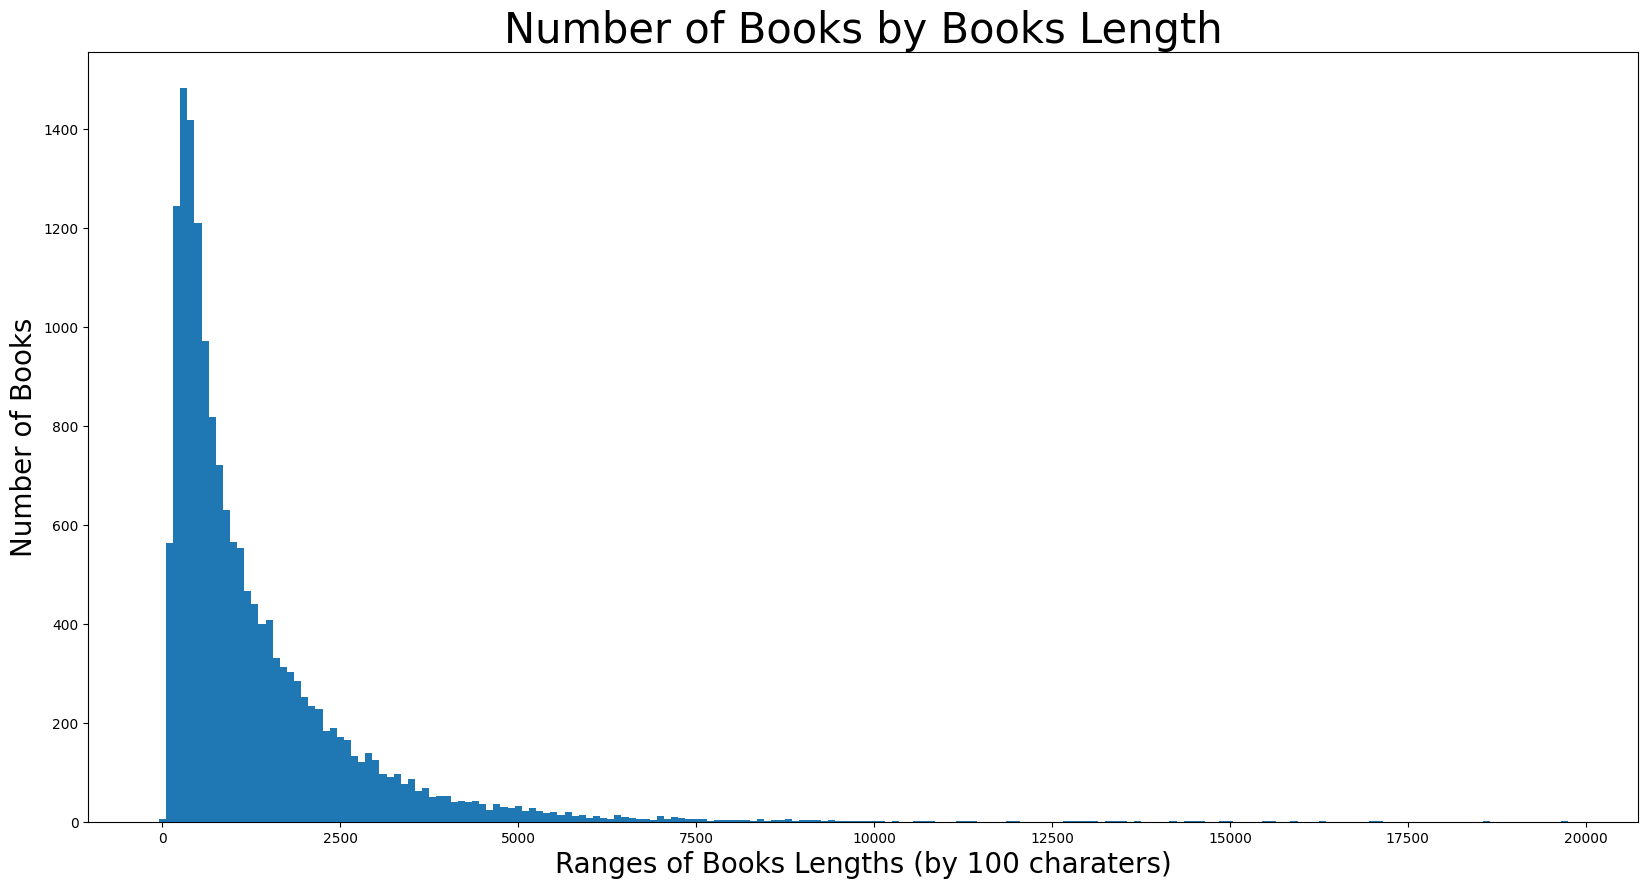

In [20]:
length_counts = {x:rounded_to_100_lengths.count(x) for x in rounded_to_100_lengths}
print(sorted(length_counts.items())[:5])

x = [tup[0] for tup in sorted(length_counts.items())]
y = [tup[1] for tup in sorted(length_counts.items())]

plt.figure(figsize=(20,10))
plt.bar(x,y, width=100)
plt.title('Number of Books by Books Length', fontsize=30)
plt.xlabel("Ranges of Books Lengths (by 100 charaters)", fontsize=20)
plt.ylabel("Number of Books", fontsize=20)
plt.show()

In [21]:
books['Summary length'] = books['Summary'].apply(len)
books = books[books['Summary length'] >= 50]
books.reset_index(drop=True, inplace=True)
books

,ID,Title,Author,Publication Date,Genres,Summary,Summary length
0,620,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...",major manor calls animals meeting compares hum...,3232
1,843,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...",teenager living nearfuture england leads night...,3379
2,986,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",plague divided parts thousands initially unnot...,3439
3,1756,An Enquiry Concerning Human Understanding,David Hume,,[],argument enquiry proceeds incremental steps se...,8771
4,2080,A Fire Upon the Deep,Vernor Vinge,,"[Hard science fiction, Science Fiction, Specul...",posits space milky divided concentric layers z...,2642
...,...,...,...,...,...,...,...
16395,36934824,Under Wildwood,Colin Meloy,2012-09-25,[],mckeel rescued dowager governess conclusion no...,504
16396,37054020,Transfer of Power,Vince Flynn,2000-06-01,"[Thriller, Fiction]",reader covert operation possible terrorist att...,571
16397,37122323,Decoded,Jay-Z,2010-11-16,[Autobiography],follows rough chronological switching current ...,977
16398,37132319,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,[],colbert addresses topics street campaign finan...,111


[(100, 411), (200, 1246), (300, 1483), (400, 1420), (500, 1210)]


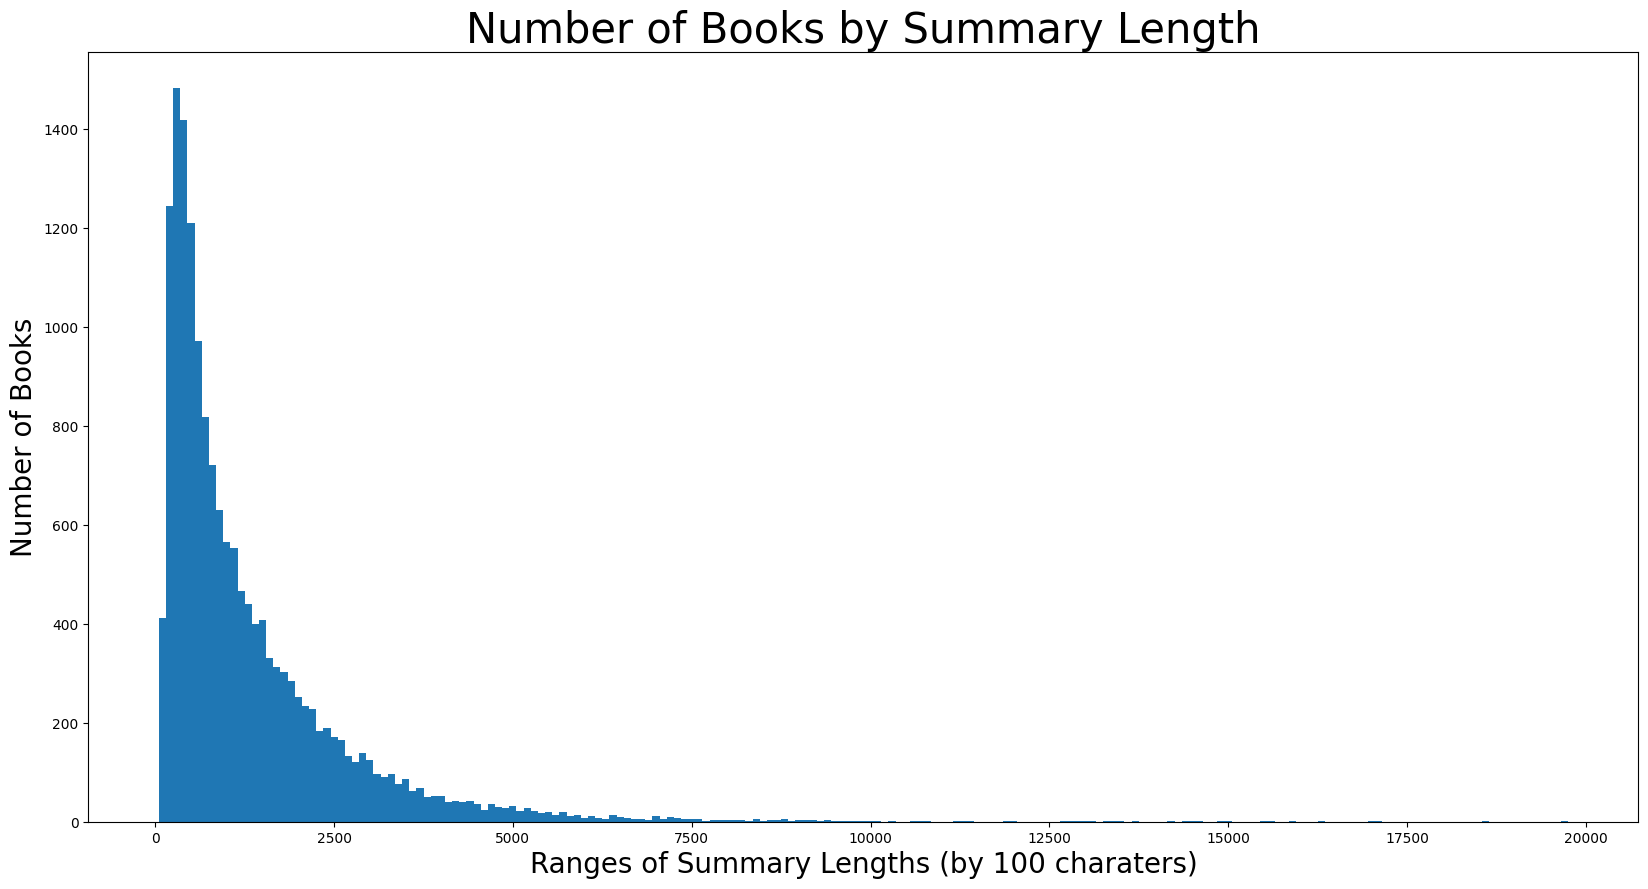

In [22]:
rounded_to_100_lengths = round_lengths(books)

length_counts = {x:rounded_to_100_lengths.count(x) for x in rounded_to_100_lengths}
print(sorted(length_counts.items())[:5])

x = [tup[0] for tup in sorted(length_counts.items())]
y = [tup[1] for tup in sorted(length_counts.items())]

plt.figure(figsize=(20,10))
plt.bar(x,y, width=100)
plt.title('Number of Books by Summary Length', fontsize=30)
plt.xlabel("Ranges of Summary Lengths (by 100 charaters)", fontsize=20)
plt.ylabel("Number of Books", fontsize=20)
plt.show()

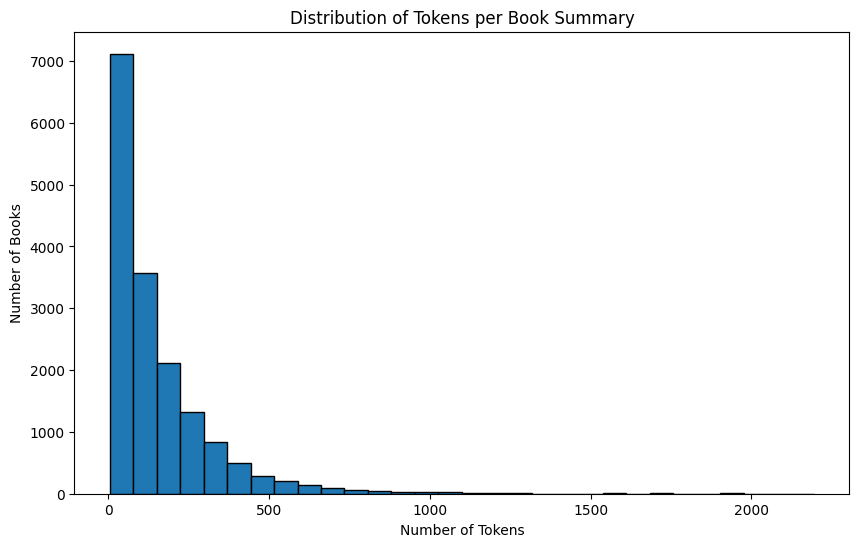

count    16400.000000
mean       153.439390
std        172.834781
min          5.000000
25%         44.000000
50%         95.000000
75%        202.000000
max       2195.000000
Name: Token Count, dtype: float64


In [23]:
books['Token Count'] = books['Summary'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(books['Token Count'], bins=30, edgecolor='black')
plt.title('Distribution of Tokens per Book Summary')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Books')
plt.show()

print(books['Token Count'].describe())

/var/folders/73/gwcs1q89075gwd2dyqhx8nyc0000gn/T/ipykernel_69745/1118085206.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  token_distribution = books.groupby(token_intervals)['Token Count'].count()


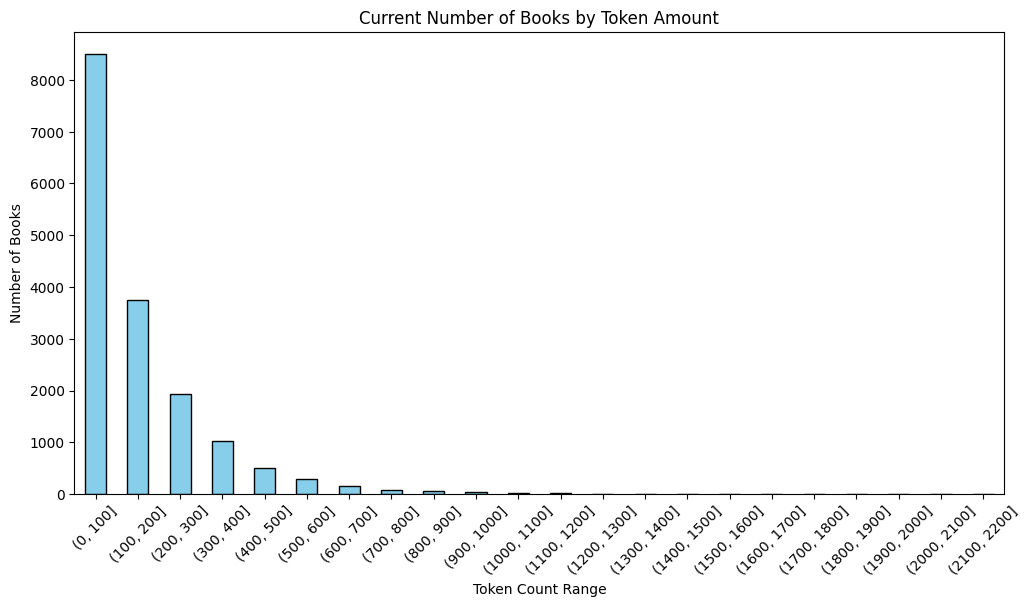

In [24]:
token_intervals = pd.cut(books['Token Count'], bins=range(0, books['Token Count'].max() + 100, 100))

token_distribution = books.groupby(token_intervals)['Token Count'].count()

plt.figure(figsize=(12, 6))
token_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Current Number of Books by Token Amount')
plt.xlabel('Token Count Range')
plt.ylabel('Number of Books')
plt.xticks(rotation=45)
plt.show()

To prevent it from increasing in the early part of the book distribution, we'll multiply the funciton by a very small decimal to keep all initial values close to 0 until such a time when the exponential increase is fast enough to overcome the initial reduction.

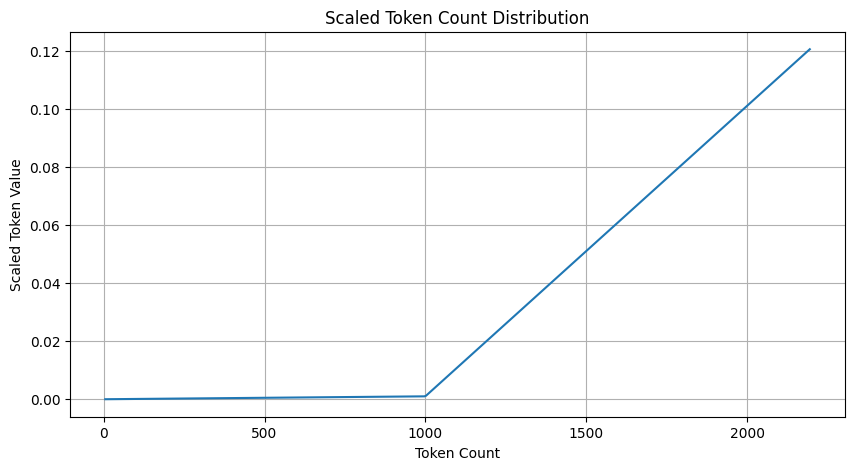

In [25]:
def scaled_token_function(token_count):
    small_factor = 0.000001  
    threshold = 1000        
    scaling_factor = 0.0001  
    
    if token_count < threshold:
        return token_count * small_factor
    else:
        return (token_count - threshold) * scaling_factor + (threshold * small_factor)

books['Scaled Token Count'] = books['Token Count'].apply(scaled_token_function)

books_sorted = books.sort_values(by='Token Count')

x_vals = books_sorted['Token Count'].values
y_vals = books_sorted['Scaled Token Count'].values

plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_vals, linestyle='solid')
plt.title('Scaled Token Count Distribution')
plt.xlabel('Token Count')
plt.ylabel('Scaled Token Value')
plt.grid(True)
plt.show()


In [26]:
from collections import Counter
from itertools import chain

text_word_frequency = Counter(chain.from_iterable(books['Summary'].str.split()))
most_common_words = text_word_frequency.most_common(15)

most_common_words

[('human', 3237),
 ('taken', 3101),
 ('earth', 3090),
 ('power', 3089),
 ('lives', 2960),
 ('money', 2921),
 ('child', 2873),
 ('gives', 2861),
 ('police', 2789),
 ('secret', 2739),
 ('attack', 2718),
 ('sister', 2711),
 ('arrives', 2640),
 ('living', 2635),
 ('known', 2618)]

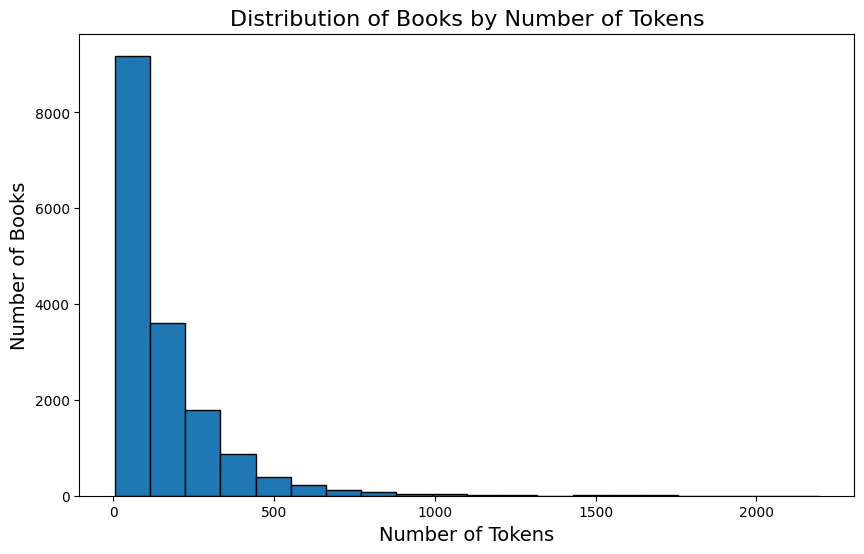

In [27]:
books['Summary Tokens'] = books['Summary'].apply(lambda x: x.split() if isinstance(x, str) else [])

book_token_counts = books['Summary Tokens'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(book_token_counts, bins=20, edgecolor='black')

plt.title('Distribution of Books by Number of Tokens', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=14)
plt.ylabel('Number of Books', fontsize=14)

plt.show()

# Model Prep

In [28]:
from gensim import corpora, models, similarities

In [29]:
tokenized_summaries = books['Summary'].apply(lambda x: x.split() if isinstance(x, str) else [])

In [30]:
%%time

dictionary = corpora.Dictionary(tokenized_summaries)

CPU times: user 1.03 s, sys: 7.71 ms, total: 1.04 s
Wall time: 1.04 s


In [31]:
from itertools import islice
def take(n, iterable):
    return list(islice(iterable, n))

items_5 = take(5, dictionary.iteritems())
items_5

[(0, 'abolishes'),
 (1, 'abuse'),
 (2, 'abuses'),
 (3, 'account'),
 (4, 'accusations')]

In [32]:
%%time

bow_corpus = [dictionary.doc2bow(text) for text in tokenized_summaries]

CPU times: user 707 ms, sys: 13.8 ms, total: 721 ms
Wall time: 730 ms


In [33]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of books: %d' % len(bow_corpus))

Number of unique tokens: 143535
Number of books: 16400


In [34]:
print(bow_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 4), (12, 1), (13, 1), (14, 1), (15, 1), (16, 13), (17, 3), (18, 23), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 3), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 9), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 3), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 6), (88, 2), (89, 1), (90, 1), (91, 3), (92, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 2), (99, 1), (100, 1), (101, 1), (102, 1), (103, 3), (104, 1), (105, 1), (106, 2), (107, 1), (108, 1), (109, 1), (110, 1

In [35]:
def tokenization_report(bow_corpus, book_number):
    book_tokens = bow_corpus[book_number]
    sorted_tokens = sorted(book_tokens, key=lambda x: x[1], reverse=True)
    for i in range(len(bow_corpus[book_number])):
        print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens[i][0],
                                                            dictionary[sorted_tokens[i][0]],
                                                            sorted_tokens[i][1]))
tokenization_report(bow_corpus, 0)

Word 18 ("animals") appears 23 time(s).
Word 145 ("napoleon") appears 19 time(s).
Word 16 ("animal") appears 13 time(s).
Word 55 ("commandments") appears 9 time(s).
Word 206 ("shall") appears 9 time(s).
Word 213 ("snowball") appears 9 time(s).
Word 217 ("squealer") appears 8 time(s).
Word 111 ("humans") appears 7 time(s).
Word 87 ("equal") appears 6 time(s).
Word 240 ("windmill") appears 6 time(s).
Word 205 ("seven") appears 5 time(s).
Word 11 ("alcohol") appears 4 time(s).
Word 17 ("animalism") appears 3 time(s).
Word 28 ("attempts") appears 3 time(s).
Word 35 ("better") appears 3 time(s).
Word 38 ("boxer") appears 3 time(s).
Word 46 ("changes") appears 3 time(s).
Word 77 ("drink") appears 3 time(s).
Word 91 ("faces") appears 3 time(s).
Word 103 ("harder") appears 3 time(s).
Word 210 ("sleep") appears 3 time(s).
Word 20 ("announces") appears 2 time(s).
Word 29 ("beasts") appears 2 time(s).
Word 52 ("clothes") appears 2 time(s).
Word 61 ("control") appears 2 time(s).
Word 86 ("england"

# Determining Optimal Number of Topics

In [36]:
from gensim.models import CoherenceModel
import gensim

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []

    print("Computing coherence values...")
    for num_topics in range(start, limit, step):
        print(f"Training LDA with {num_topics} topics...")
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                    num_topics=num_topics, 
                                                    id2word=dictionary, 
                                                    random_state=123,
                                                    passes=10, 
                                                    iterations=100, 
                                                    chunksize=2000)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        print(f"Coherence Score for {num_topics} topics: {coherence_score}")
        coherence_values.append(coherence_score)

    print("Coherence value computation complete.")
    return model_list, coherence_values


In [37]:
results = {}
model_list, coherence_values = compute_coherence_values(dictionary = dictionary,
                                                        corpus = bow_corpus,
                                                        texts = tokenized_summaries,
                                                        start = 2,
                                                        limit = 50,
                                                        step = 2)
results['books'] = {'model_list': model_list, 'coherence_values': coherence_values}
print("Coherence values:", coherence_values)

Computing coherence values...
Training LDA with 2 topics...
Coherence Score for 2 topics: 0.40680377088259057
Training LDA with 4 topics...
Coherence Score for 4 topics: 0.39335959109249885
Training LDA with 6 topics...
Coherence Score for 6 topics: 0.4183251979790594
Training LDA with 8 topics...
Coherence Score for 8 topics: 0.4231075899153824
Training LDA with 10 topics...
Coherence Score for 10 topics: 0.45179028644473573
Training LDA with 12 topics...
Coherence Score for 12 topics: 0.4689243883121794
Training LDA with 14 topics...
Coherence Score for 14 topics: 0.5023146777589865
Training LDA with 16 topics...
Coherence Score for 16 topics: 0.4826980229884007
Training LDA with 18 topics...
Coherence Score for 18 topics: 0.5295782233124863
Training LDA with 20 topics...
Coherence Score for 20 topics: 0.5228706705027558
Training LDA with 22 topics...
Coherence Score for 22 topics: 0.5443983527206003
Training LDA with 24 topics...
Coherence Score for 24 topics: 0.5389169941998181
Tra

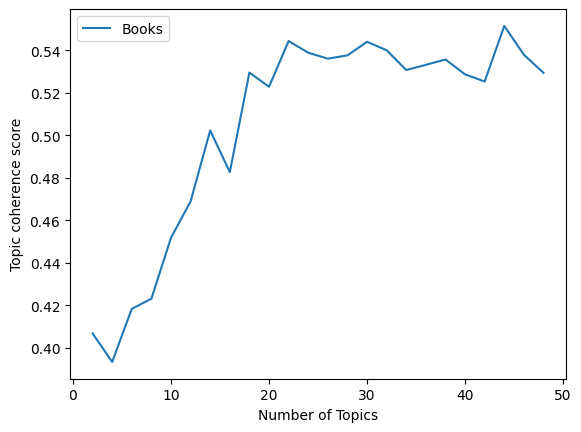

In [38]:
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, results['books']['coherence_values'], label="Books")
plt.xlabel("Number of Topics")
plt.ylabel("Topic coherence score")
plt.legend()
plt.show()

In [39]:
results = {}
model_list, coherence_values = compute_coherence_values(dictionary = dictionary,
                                                        corpus = bow_corpus,
                                                        texts = tokenized_summaries,
                                                        start = 2,
                                                        limit = 200,
                                                        step = 2)
results['books'] = {'model_list': model_list, 'coherence_values': coherence_values}
print("Coherence values:", coherence_values)

Computing coherence values...
Training LDA with 2 topics...
Coherence Score for 2 topics: 0.40680377088259057
Training LDA with 4 topics...
Coherence Score for 4 topics: 0.39335959109249885
Training LDA with 6 topics...
Coherence Score for 6 topics: 0.4183251979790594
Training LDA with 8 topics...
Coherence Score for 8 topics: 0.4231075899153824
Training LDA with 10 topics...
Coherence Score for 10 topics: 0.45179028644473573
Training LDA with 12 topics...
Coherence Score for 12 topics: 0.4689243883121794
Training LDA with 14 topics...
Coherence Score for 14 topics: 0.5023146777589865
Training LDA with 16 topics...
Coherence Score for 16 topics: 0.4826980229884007
Training LDA with 18 topics...
Coherence Score for 18 topics: 0.5295782233124863
Training LDA with 20 topics...
Coherence Score for 20 topics: 0.5228706705027558
Training LDA with 22 topics...
Coherence Score for 22 topics: 0.5443983527206003
Training LDA with 24 topics...
Coherence Score for 24 topics: 0.5389169941998181
Tra

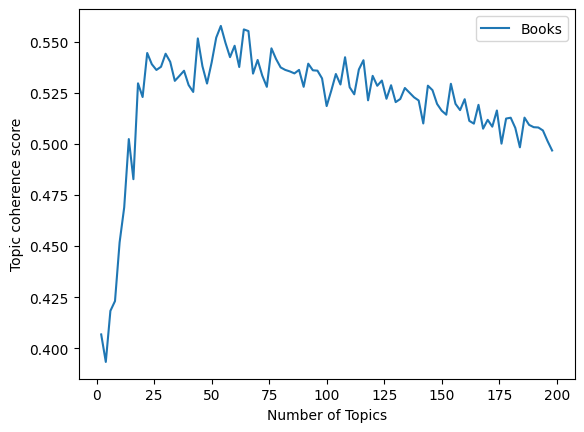

In [40]:
limit=200; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, results['books']['coherence_values'], label="Books")
plt.xlabel("Number of Topics")
plt.ylabel("Topic coherence score")
plt.legend()
plt.show()

Based on the graphs, coherence values reach a peak around 50-60.

In [41]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=50, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.530173793277887


In [42]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=51, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.5359796598776706


In [43]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=52, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.5296548995558924


In [44]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=53, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.537431926969395


In [45]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=54, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.5492707427436058


In [46]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=55, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.5360611516602904


In [47]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=56, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.527169876326153


In [48]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=57, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.5576944046479198


In [49]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=58, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.5256170427183038


In [50]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=59, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.5489195039895753


In [51]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=60, id2word=dictionary, random_state=123)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, 
                                 texts=tokenized_summaries, 
                                 dictionary=dictionary, 
                                 coherence='c_v')

coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score : ', coherence_lda)


Coherence Score :  0.5263342515833653


**The optimal number of topics is 57 topics, as it has the highest coherence value.** 

# LDA with 57 topics

In [52]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=57, id2word=dictionary, random_state=123)

topic_doc_matrix = lda_model[bow_corpus]

sorted_topic_doc_matrix = [
    sorted(doc_topics, key=lambda x: x[0])
    for doc_topics in topic_doc_matrix
]

num_topics = 57
for doc_topics in sorted_topic_doc_matrix:
    present_topic_ids = set(topic[0] for topic in doc_topics)
    missing_topic_ids = set(range(num_topics)) - present_topic_ids

    doc_topics.extend([(topic_id, 0) for topic_id in missing_topic_ids])
    doc_topics.sort(key=lambda x: x[0])

In [53]:
topic_doc_matrix[200]

[(7, 0.05533135),
 (13, 0.03450626),
 (21, 0.25692075),
 (22, 0.23602201),
 (28, 0.015218648),
 (34, 0.17162542),
 (35, 0.023963189),
 (37, 0.046119805),
 (56, 0.14025368)]

In [54]:
sorted_topic_doc_matrix[200]

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0.055132825),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0.034357663),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 0),
 (21, 0.2566444),
 (22, 0.23598348),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0.015179606),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0.17160909),
 (35, 0.02396558),
 (36, 0),
 (37, 0.04558866),
 (38, 0),
 (39, 0),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 0),
 (44, 0),
 (45, 0),
 (46, 0),
 (47, 0),
 (48, 0),
 (49, 0),
 (50, 0),
 (51, 0),
 (52, 0),
 (53, 0),
 (54, 0),
 (55, 0),
 (56, 0.14039154)]

In [55]:
np.save('Models/topic-doc',sorted_topic_doc_matrix)

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
topic_doc_matrix_array = [list(map(lambda x: x[1], doc_topics)) for doc_topics in sorted_topic_doc_matrix]
topic_doc_matrix_array = np.array(topic_doc_matrix_array)

similarity_matrix = cosine_similarity(topic_doc_matrix_array)

np.save('Models/similarity_matrix', similarity_matrix)

In [57]:
similarity_matrix

array([[1.        , 0.16589129, 0.31842102, ..., 0.3281653 , 0.02454952,
        0.12313054],
       [0.16589129, 1.        , 0.20703232, ..., 0.47425091, 0.01822351,
        0.40885998],
       [0.31842102, 0.20703232, 1.        , ..., 0.34496296, 0.01001892,
        0.13997585],
       ...,
       [0.3281653 , 0.47425091, 0.34496296, ..., 1.        , 0.03615375,
        0.29024913],
       [0.02454952, 0.01822351, 0.01001892, ..., 0.03615375, 1.        ,
        0.        ],
       [0.12313054, 0.40885998, 0.13997585, ..., 0.29024913, 0.        ,
        1.        ]])

In [58]:
pip install pyLDAvis


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="This process .* multi-threaded.*")
warnings.filterwarnings("ignore", message="datetime.datetime.utcfromtimestamp.*")

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)

/Users/biancaleoveanu/Library/Python/3.12/lib/python/site-packages/dateutil/tz/tz.py:37: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  EPOCH = datetime.datetime.utcfromtimestamp(0)
/Users/biancaleoveanu/Library/Python/3.12/lib/python/site-packages/dateutil/tz/tz.py:37: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  EPOCH = datetime.datetime.utcfromtimestamp(0)
/Users/biancaleoveanu/Library/Python/3.12/lib/python/site-packages/dateutil/tz/tz.py:37: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes i

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
20    -0.200166  0.173793       1        1  11.676889
56    -0.204918 -0.017184       2        1  11.668756
3     -0.198756  0.033504       3        1  10.477839
21    -0.195062 -0.129278       4        1   9.140942
9     -0.179727 -0.004780       5        1   5.058027
37    -0.186077  0.101122       6        1   4.912071
10    -0.180361  0.070854       7        1   4.833501
49    -0.168735 -0.095874       8        1   4.480174
34    -0.156979 -0.169128       9        1   4.252864
5     -0.156700 -0.038151      10        1   3.731387
51    -0.158060  0.115706      11        1   3.280471
7     -0.147822 -0.013403      12        1   2.889716
28    -0.119639 -0.212432      13        1   2.347236
38    -0.087686 -0.033333      14        1   1.873472
16    -0.095777  0.074982      15        1   1.231095
44    -0.071365  0.022431      16        1   1.025839
4     -0.054052 -0.066785      17        1   0.934001
13    -0.053062 -0.011257      18        1   0.909792
12    -0.066458  0.044041      19        1   0.830179
23    -0.020006 -0.010268      20        1   0.818449
55    -0.032895 -0.057271      21        1   0.791613
31    -0.016408  0.012466      22        1   0.722378
35    -0.012771  0.071234      23        1   0.702461
36    -0.024827  0.041615      24        1   0.670358
0     -0.023827  0.066741      25        1   0.611285
29    -0.009272  0.096353      26        1   0.586598
1      0.011358 -0.009343      27        1   0.510212
6     -0.006319 -0.025902      28        1   0.508043
46    -0.000612 -0.050410      29        1   0.455226
19     0.040323  0.039180      30        1   0.450012
17     0.039287  0.054046      31        1   0.440742
39     0.054392 -0.041041      32        1   0.424793
42     0.035691  0.044456      33        1   0.419147
24     0.032848  0.029998      34        1   0.415571
50     0.038304 -0.001970      35        1   0.403076
41     0.063618  0.010172      36        1   0.402498
47     0.054788 -0.043803      37        1   0.382723
11     0.029324  0.026194      38        1   0.379696
53     0.036785  0.045521      39        1   0.362829
54     0.085221  0.015058      40        1   0.356367
52     0.086611  0.065959      41        1   0.331740
14     0.056280 -0.034675      42        1   0.331578
18     0.074387 -0.055410      43        1   0.257378
33     0.152418  0.033633      44        1   0.247745
25     0.092269 -0.026385      45        1   0.234219
43     0.136730  0.030474      46        1   0.233697
8      0.096624 -0.035031      47        1   0.230035
30     0.109078 -0.064996      48        1   0.221262
45     0.118995 -0.062401      49        1   0.216801
40     0.130525 -0.041676      50        1   0.207048
27     0.167864  0.052420      51        1   0.206905
2      0.124981  0.017996      52        1   0.200007
32     0.167949 -0.013618      53        1   0.186824
22     0.159074  0.007974      54        1   0.182537
15     0.198155 -0.006685      55        1   0.145048
26     0.192624 -0.020550      56        1   0.100554
48     0.241835 -0.004885      57        1   0.098291, topic_info=            Term         Freq        Total Category  logprob  loglift
29010      jacky  1251.000000  1251.000000  Default  30.0000  30.0000
4462      thomas  1371.000000  1371.000000  Default  29.0000  29.0000
1078      heaven  1520.000000  1520.000000  Default  28.0000  28.0000
6892     michael   980.000000   980.000000  Default  27.0000  27.0000
3588   christian  1026.000000  1026.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
34498     nebula     4.751615     8.837710  Topic57  -6.2549   6.3044
19094    macedon     4.139188     7.220798  Topic57  -6.3929   6.3685
6924    colleges     9.628617    37.493460  Topic57  -5.5486   5.5656
30462     quinns     6.787814    20.924987  Topic57  -5.8982   5.7992
1

# t-SNE visualization of paintings based on their principal topic ( topic with highest distribution )

In [60]:
from sklearn.manifold import TSNE

lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=57, id2word=dictionary, random_state=123)
topic_doc_matrix = lda_model[bow_corpus]

hm = np.zeros((len(bow_corpus), 57))

for i, doc_topics in enumerate(topic_doc_matrix):
    for topic_id, topic_prob in doc_topics:
        hm[i, topic_id] = topic_prob

tsne = TSNE(random_state=2017, perplexity=30, early_exaggeration=12)  
embedding = tsne.fit_transform(hm)

embedding = pd.DataFrame(embedding, columns=['x', 'y'])
embedding['hue'] = hm.argmax(axis=1)  

In [61]:
pip install bokeh


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
from bokeh.plotting import ColumnDataSource, figure, show
from bokeh.models import HoverTool, CustomJS
from bokeh.palettes import all_palettes
import pandas as pd

colors = [all_palettes['Set3'][11][w % 11] for w in embedding.hue]

source = ColumnDataSource(
    data=dict(
        x=embedding['x'],
        y=embedding['y'],
        title=books['Title'],  
        author=books['Author'],  
        colors=colors,
        alpha=[0.9] * embedding.shape[0],
        size=[7] * embedding.shape[0]
    )
)

hover_tsne = HoverTool(name="df", tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Author:</span>
            <span style="font-size: 12px">@author</span>
            <br>
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
        </div>
    </div>
""")

tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset', 'save']
plot_tsne = figure(width=700, height=700, tools=tools_tsne, title='t-SNE visualization of books by topic')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var f = cb_obj.value;
    x = data['x'];
    y = data['y'];
    colors = data['colors'];
    alpha = data['alpha'];
    author = data['author'];
    title = data['title'];
    size = data['size'];
    for (var i = 0; i < x.length; i++) {
        if (/* replace with actual condition */) {
            alpha[i] = 0.9;
            size[i] = 7;
        } else {
            alpha[i] = 0.05;
            size[i] = 4;
        }
    }
    source.change.emit();
""")

show(plot_tsne)

In [63]:
lda_model.print_topics()

[(30,
  '0.063*"roger" + 0.023*"wally" + 0.014*"rogers" + 0.013*"everett" + 0.011*"treehouse" + 0.006*"grayson" + 0.005*"marie" + 0.005*"scrapbook" + 0.004*"trent" + 0.004*"dwight"'),
 (23,
  '0.016*"eddie" + 0.015*"dawkins" + 0.010*"oscar" + 0.010*"blake" + 0.009*"wicked" + 0.009*"leigh" + 0.009*"burton" + 0.006*"religion" + 0.006*"mouse" + 0.004*"steven"'),
 (39,
  '0.018*"marcus" + 0.016*"jester" + 0.013*"egypt" + 0.013*"locomotive" + 0.011*"miranda" + 0.010*"pharaoh" + 0.008*"roman" + 0.007*"conrad" + 0.006*"seymour" + 0.006*"andrea"'),
 (5,
  '0.008*"magic" + 0.006*"earth" + 0.005*"harry" + 0.005*"monkey" + 0.004*"magical" + 0.004*"giant" + 0.004*"water" + 0.004*"wizard" + 0.004*"animals" + 0.003*"forest"'),
 (4,
  '0.053*"heaven" + 0.019*"stevie" + 0.012*"conan" + 0.008*"heavens" + 0.008*"jesus" + 0.006*"angel" + 0.006*"furnace" + 0.006*"marco" + 0.005*"egyptian" + 0.004*"oregon"'),
 (29,
  '0.037*"natalie" + 0.022*"kitty" + 0.022*"cassie" + 0.012*"grace" + 0.010*"tucker" + 0.010

In [64]:
def topic2words(topic_id, topn):
    list_topics = lda_model.get_topic_terms(topic_id, topn)
    words_with_probs = [(dictionary[tup[0]], tup[1]) for tup in list_topics]
    return words_with_probs

In [65]:
topic2words(7, 10)

[('narrator', 0.009227227),
 ('dresden', 0.0086121475),
 ('dylan', 0.006523649),
 ('harris', 0.0026402897),
 ('books', 0.002465482),
 ('reader', 0.0023149566),
 ('section', 0.0022444495),
 ('events', 0.0021388817),
 ('human', 0.0020834669),
 ('narrators', 0.0020667277)]

In [66]:
topic2words(6, 10)

[('artemis', 0.029782362),
 ('jesse', 0.025534047),
 ('holly', 0.012685035),
 ('drake', 0.008120292),
 ('megan', 0.0074957297),
 ('hitler', 0.0071366914),
 ('clinic', 0.0059857694),
 ('mcbride', 0.0056231273),
 ('enterprises', 0.004859458),
 ('adele', 0.0048456267)]

# Top-K Recommendations

In [67]:
class LDAEngine():
    def __init__(self):
        self.books_df = books 
        self.cos_mat = np.load("Models/similarity_matrix.npy")  

    def unpack_prefs(self, preferences):
        book_list = []
        weights = []
        for book, rating in preferences.items():
            book_list.append(book)
            weights.append(rating)
        xmin = min(weights)
        xmax = max(weights)
        for i, x in enumerate(weights):
            weights[i] = (x - xmin) / (xmax - xmin + sys.float_info.epsilon)
        return book_list, weights

    def index2book_id(self, books_df, index):
        """From the index, returns the book ID from the books dataframe"""
        try:
            book_id = books_df.iloc[index]['ID'] 
        except IndexError:
            book_id = f"Index '{index}' not found in dataset."
        return book_id
        
    def indexlist2booktitlelist(self, books_df, index_list):
        """From a list of indices, returns the book titles."""
        book_titles_list = [books_df.iloc[index]["Title"] for index in index_list]
        return book_titles_list
        
    def indexlist2bookidlist(self, books_df, index_list):
        """From a list of indexes, returns the book IDs"""
        book_ids_list = [self.index2book_id(books_df, index) for index in index_list]
        return book_ids_list

    def bookid2index(self, books_df, book_id):
        """From the book ID, returns the index of the book in the books dataframe"""
        try:
            index = books_df.loc[books_df['ID'] == book_id].index[0]
        except IndexError:
            index = f"Book ID '{book_id}' not found in dataset."
        return index

    def bookidlist2indexlist(self, books_df, book_list):
        """From a list of book IDs, returns the indexes of the books"""
        index_list = [self.bookid2index(books_df, book_id) for book_id in book_list]
        return index_list

    def retrieval(self, preferences, n=3):
        """Recommend books for a user based on preferences."""
        book_list, weights = self.unpack_prefs(preferences)

        n_books = len(book_list)
        score_list = []
        index_list = self.bookidlist2indexlist(self.books_df, book_list)

        weights = np.asarray(weights).reshape(-1, 1)
        for index in index_list:
            score = self.cos_mat[index]
            score[index] = 0
            score_list.append(score)

        score_list = np.sum(np.multiply(weights, score_list), axis=0) / n_books
        top_n_index = sorted(range(len(score_list)), key=lambda i: score_list[i], reverse=True)[:n]

        top_n_titles = self.indexlist2booktitlelist(self.books_df, top_n_index)

        return list(top_n_titles)

In [68]:
def doc_topics(index, sorted_topic_doc_matrix):
    """
    Visualize topic proportions for a specific book based on its index.
    """
    sns.set(style="whitegrid")
    topics = range(len(sorted_topic_doc_matrix[index]))   
    proportions = [topic[1] for topic in sorted_topic_doc_matrix[index]]
    
    fig, ax = plt.subplots()
    ax.bar(topics, proportions)
    
    ax.set_xlabel('Topics')
    ax.set_ylabel('Proportion')
    ax.set_title(f'Proportions of the topics for book index {index}')
    ax.set_xticks(topics)
    
    plt.show()

def recommend_books(books_df, book_list, cos_mat, n):
    """
    Recommend books for a user based on a list of liked books.

    Parameters:
        books_df: DataFrame containing book information.
        book_list: List of book IDs liked by the user.
        cos_mat: Cosine similarity matrix.
        n: Number of recommendations.

    Returns:
        List of recommended book IDs.
    """
    n_books = len(book_list)
    score_list = []
    index_list = eng.bookidlist2indexlist(books_df, book_list)
    
    for index in index_list:
        score = cos_mat[index]
        score[index] = 0 
        score_list.append(score)
    
    score_list = np.sum(score_list, axis=0) / n_books 
    top_n_index = sorted(range(len(score_list)), key=lambda i: score_list[i], reverse=True)[:n]
    top_n_titles = [books_df.iloc[i]["Title"] for i in top_n_index]
    
    return top_n_titles

In [69]:
import random

# Select random book IDs from the dataset and assign a rating of 5
random_book_ids = random.sample(list(books['ID']), 10)
preferences = {book_id: 5 for book_id in random_book_ids}
print(preferences)

{'14389105': 5, '64594': 5, '2052886': 5, '2292610': 5, '3136512': 5, '19586494': 5, '55737': 5, '14913203': 5, '29914982': 5, '27494190': 5}


In [72]:
eng = LDAEngine()
Recommendations = eng.retrieval(preferences, n=9)
print("Recommended Books:", Recommendations)

Recommended Books: ['Animal Farm', 'A Clockwork Orange', 'The Plague', 'An Enquiry Concerning Human Understanding', 'A Fire Upon the Deep', 'All Quiet on the Western Front', 'A Wizard of Earthsea', 'Anyone Can Whistle', 'Blade Runner 3: Replicant Night']


# Model Evaluation

In [73]:
books_summaries_1 = [summary[:len(summary)//2] for summary in books['Summary']]
books_summaries_2 = [summary[len(summary)//2:] for summary in books['Summary']]

In [74]:
corpus_1 = [dictionary.doc2bow(summary.split()) for summary in books_summaries_1]
corpus_2 = [dictionary.doc2bow(summary.split()) for summary in books_summaries_2]

In [75]:
lda_corpus_1 = lda_model[corpus_1]
lda_corpus_2 = lda_model[corpus_2]

In [76]:
from collections import OrderedDict
def book_topic_dist(model, corpus, num_topics):
    topic_distributions = []
    for doc in corpus:
        topic_dist = {i: 0 for i in range(num_topics)}
        topic_dist.update(dict(model[doc]))
        topic_distributions.append(np.array(list(OrderedDict(topic_dist).values())))
    return np.array(topic_distributions)

In [77]:
top_dist_1 = book_topic_dist(lda_model, lda_corpus_1, lda_model.num_topics)
top_dist_2 = book_topic_dist(lda_model, lda_corpus_2, lda_model.num_topics)

In [78]:
intra_similarity = np.mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1, c2 in zip(top_dist_1, top_dist_2)])
print(f"Intra similarity (higher is better): {intra_similarity}")

random_pairs = np.random.randint(0, len(books), size=(400, 2))
inter_similarity = np.mean([cosine_similarity(top_dist_1[i[0]].reshape(1, -1), top_dist_2[i[1]].reshape(1, -1))[0][0] for i in random_pairs])
print(f"Inter similarity (lower is better): {inter_similarity}")

similarity_difference = intra_similarity - inter_similarity
print(f"Similarity difference: {similarity_difference}")

Intra similarity (higher is better): 0.5004161725024352
Inter similarity (lower is better): 0.24702310518743953
Similarity difference: 0.25339306731499567
